In [42]:
# ============================================
# NOTEBOOK 03: BASELINE MODEL - LOGISTIC REGRESSION
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_auc_score, roc_curve,
                             precision_recall_curve, log_loss)
from sklearn.preprocessing import StandardScaler
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [43]:
# ============================================
# LOAD ENGINEERED FEATURES
# ============================================

print("\n" + "="*60)
print("LOADING ENGINEERED FEATURES")
print("="*60)

df = pd.read_csv('C:/Users/imadn/GitHub/ctr-prediction/data/processed/ctr_features_engineered.csv')

print(f"Loaded {len(df):,} rows")
print(f"Columns: {len(df.columns)}")

# Separate features and target
X = df.drop('click', axis=1)
y = df['click']

print(f"\nFeatures (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"CTR: {y.mean()*100:.2f}%")


LOADING ENGINEERED FEATURES
Loaded 1,000,000 rows
Columns: 23

Features (X): (1000000, 22)
Target (y): (1000000,)
CTR: 16.02%


In [44]:
# ============================================
# TRAIN/TEST SPLIT
# ============================================

print("\n" + "="*60)
print("TRAIN/TEST SPLIT")
print("="*60)

# Split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

print(f"\nTrain CTR: {y_train.mean()*100:.2f}%")
print(f"Test CTR: {y_test.mean()*100:.2f}%")

print(f"\nClass distribution in training:")
print(y_train.value_counts())
print(f"Imbalance ratio: 1:{int((y_train==0).sum()/(y_train==1).sum())}")


TRAIN/TEST SPLIT
Training set: 800,000 samples (80.0%)
Test set: 200,000 samples (20.0%)

Train CTR: 16.02%
Test CTR: 16.02%

Class distribution in training:
click
0    671825
1    128175
Name: count, dtype: int64
Imbalance ratio: 1:5


In [45]:
# ============================================
# FEATURE SCALING
# ============================================

print("\n" + "="*60)
print("FEATURE SCALING")
print("="*60)

# Standardize features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")
print(f"Train shape: {X_train_scaled.shape}")
print(f"Test shape: {X_test_scaled.shape}")


FEATURE SCALING
Features scaled using StandardScaler
Train shape: (800000, 22)
Test shape: (200000, 22)


In [46]:
# ============================================
# BASELINE MODEL: LOGISTIC REGRESSION
# ============================================

print("\n" + "="*60)
print("TRAINING LOGISTIC REGRESSION")
print("="*60)

# Train with class_weight='balanced' to handle imbalance
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',  # Important for imbalanced data!
    solver='lbfgs',
    n_jobs=-1
)

print("Training model...")
lr_model.fit(X_train_scaled, y_train)
print("Model trained!")


TRAINING LOGISTIC REGRESSION
Training model...
Model trained!


In [47]:
# ============================================
# PREDICTIONS
# ============================================

print("\n" + "="*60)
print("MAKING PREDICTIONS")
print("="*60)

# Predict probabilities
y_train_proba = lr_model.predict_proba(X_train_scaled)[:, 1]
y_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Predict classes (default threshold = 0.5)
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

print("Predictions complete")
print(f"Predicted positive rate (train): {y_train_pred.mean()*100:.2f}%")
print(f"Predicted positive rate (test): {y_test_pred.mean()*100:.2f}%")


MAKING PREDICTIONS
Predictions complete
Predicted positive rate (train): 45.69%
Predicted positive rate (test): 45.56%


In [48]:
# ============================================
# EVALUATION METRICS
# ============================================

print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

# Calculate metrics
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

train_logloss = log_loss(y_train, y_train_proba)
test_logloss = log_loss(y_test, y_test_proba)

print("\nACCURACY:")
print(f"  Train: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"  Test:  {test_acc:.4f} ({test_acc*100:.2f}%)")

print("\nAUC-ROC:")
print(f"  Train: {train_auc:.4f}")
print(f"  Test:  {test_auc:.4f}")

print("\nLOG LOSS:")
print(f"  Train: {train_logloss:.4f}")
print(f"  Test:  {test_logloss:.4f}")

# Calculate improvement over random baseline
random_auc = 0.5
improvement = (test_auc - random_auc) / random_auc * 100

print(f"\nImprovement over random: {improvement:.1f}%")
print(f"(Random AUC = 0.5, Our AUC = {test_auc:.4f})")



MODEL EVALUATION

ACCURACY:
  Train: 0.5969 (59.69%)
  Test:  0.5987 (59.87%)

AUC-ROC:
  Train: 0.6880
  Test:  0.6894

LOG LOSS:
  Train: 0.6136
  Test:  0.6133

Improvement over random: 37.9%
(Random AUC = 0.5, Our AUC = 0.6894)


In [49]:
# ============================================
# CLASSIFICATION REPORT
# ============================================

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)

print("\nTest Set Performance:")
print(classification_report(y_test, y_test_pred, 
                          target_names=['No Click', 'Click'],
                          digits=4))


CLASSIFICATION REPORT

Test Set Performance:
              precision    recall  f1-score   support

    No Click     0.9027    0.5852    0.7101    167956
       Click     0.2354    0.6695    0.3484     32044

    accuracy                         0.5987    200000
   macro avg     0.5691    0.6273    0.5292    200000
weighted avg     0.7958    0.5987    0.6521    200000




CONFUSION MATRIX

Confusion Matrix:
[[98281 69675]
 [10590 21454]]

True Negatives:  98,281
False Positives: 69,675
False Negatives: 10,590
True Positives:  21,454

False Positive Rate: 41.48%
False Negative Rate: 33.05%


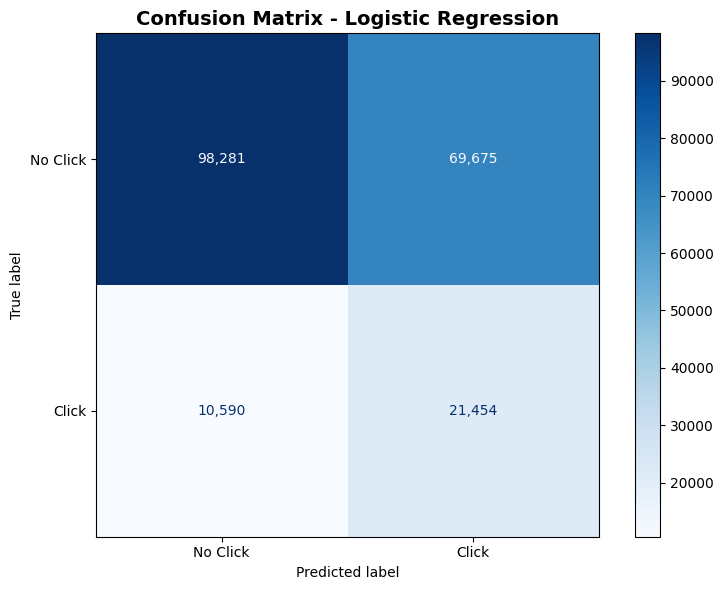


Saved: confusion_matrix_lr.png


In [50]:
# ============================================
# CONFUSION MATRIX
# ============================================

print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(y_test, y_test_pred)

print("\nConfusion Matrix:")
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives:  {cm[1,1]:,}")

# Calculate rates
tn, fp, fn, tp = cm.ravel()
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)

print(f"\nFalse Positive Rate: {false_positive_rate*100:.2f}%")
print(f"False Negative Rate: {false_negative_rate*100:.2f}%")

# Visualize
os.makedirs('../results/visualizations', exist_ok=True)

from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['No Click', 'Click']
)
disp.plot(ax=ax, cmap='Blues', values_format=',')
plt.title('Confusion Matrix - Logistic Regression', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('C:/Users/imadn/GitHub/ctr-prediction/results/visualizations/confusion_matrix_lr.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: confusion_matrix_lr.png")


ROC CURVE


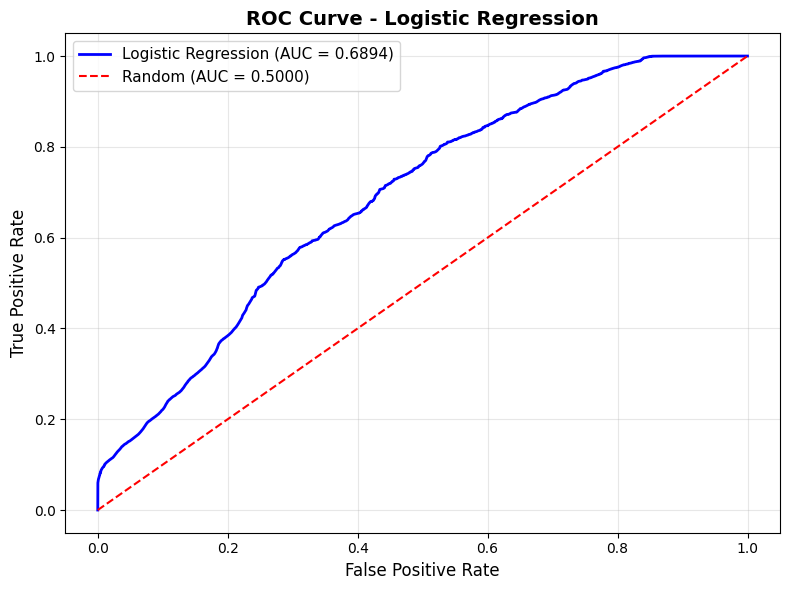

AUC-ROC: 0.6894

Saved: roc_curve_lr.png


In [52]:
# ============================================
# ROC CURVE
# ============================================

print("\n" + "="*60)
print("ROC CURVE")
print("="*60)

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='blue', linewidth=2, label=f'Logistic Regression (AUC = {test_auc:.4f})')
ax.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random (AUC = 0.5000)')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve - Logistic Regression', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('C:/Users/imadn/GitHub/ctr-prediction/results/visualizations/roc_curve_lr.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"AUC-ROC: {test_auc:.4f}")
print("\nSaved: roc_curve_lr.png")


PRECISION-RECALL CURVE


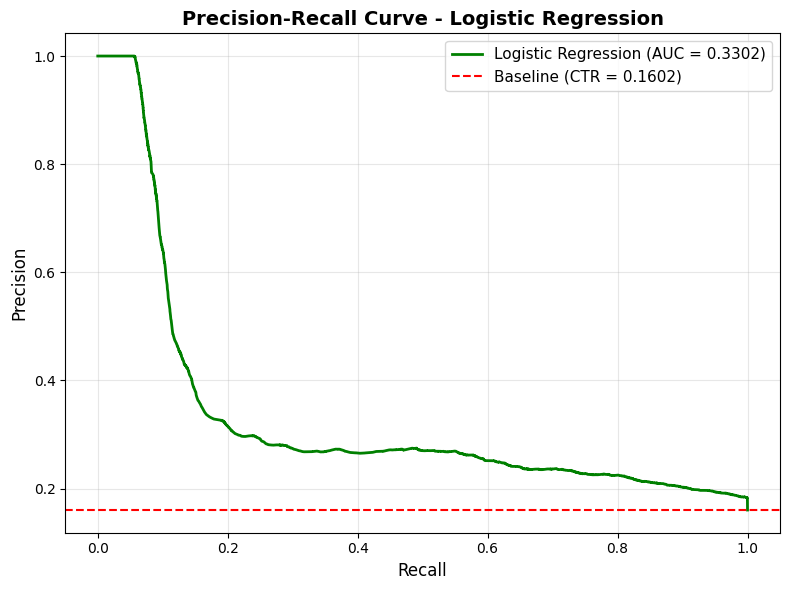

PR-AUC: 0.3302

Saved: precision_recall_curve_lr.png


In [54]:
#============================================
# PRECISION-RECALL CURVE
# ============================================

print("\n" + "="*60)
print("PRECISION-RECALL CURVE")
print("="*60)

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_test_proba)

# Calculate PR AUC
from sklearn.metrics import auc
pr_auc = auc(recall, precision)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(recall, precision, color='green', linewidth=2, label=f'Logistic Regression (AUC = {pr_auc:.4f})')
ax.axhline(y=y_test.mean(), color='red', linestyle='--', label=f'Baseline (CTR = {y_test.mean():.4f})')
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curve - Logistic Regression', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('C:/Users/imadn/GitHub/ctr-prediction/results/visualizations/precision_recall_curve_lr.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"PR-AUC: {pr_auc:.4f}")
print("\nSaved: precision_recall_curve_lr.png")


FEATURE IMPORTANCE

Top 20 Most Important Features:
                 feature   coefficient
       device_click_rate  1.269352e+00
             app_id_freq  5.313922e-01
          banner_pos_ctr  1.752566e-01
         device_type_ctr -1.744804e-01
   site_impression_count  1.701396e-01
            site_id_freq  1.701396e-01
 device_impression_count  1.508342e-01
          device_id_freq  1.508342e-01
                  c1_ctr  1.419787e-01
              C1_encoded -1.204400e-01
     device_type_encoded  6.823059e-02
device_conn_type_encoded -4.680837e-02
                hour_ctr  3.949248e-02
          device_ip_freq  3.016048e-02
             hour_of_day  1.807124e-02
      banner_pos_encoded -1.404744e-02
           timeofday_ctr  1.769004e-17
             day_of_week  0.000000e+00
            is_peak_hour  0.000000e+00
              is_weekend  0.000000e+00

Top 10 Positive Predictors (increase click probability):
                feature  coefficient
      device_click_rate     1.269

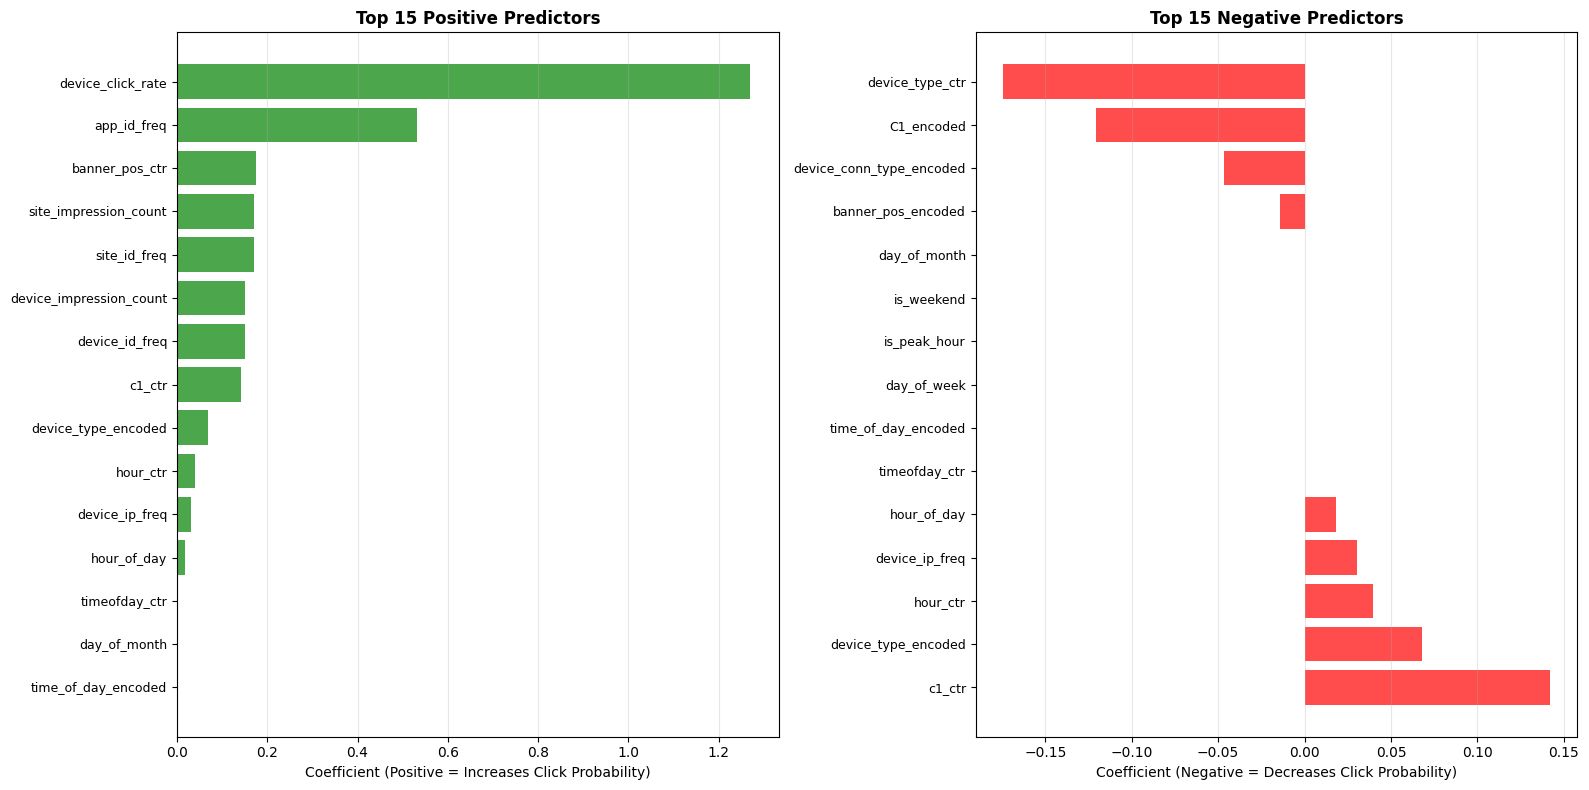


Saved: feature_importance_lr.png

Saved: feature_importance_lr.csv


In [55]:
# ============================================
# FEATURE IMPORTANCE
# ============================================

print("\n" + "="*60)
print("FEATURE IMPORTANCE")
print("="*60)

# Get feature coefficients
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_[0]
})

feature_importance['abs_coefficient'] = np.abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20)[['feature', 'coefficient']].to_string(index=False))

print("\nTop 10 Positive Predictors (increase click probability):")
print(feature_importance.sort_values('coefficient', ascending=False).head(10)[['feature', 'coefficient']].to_string(index=False))

print("\nTop 10 Negative Predictors (decrease click probability):")
print(feature_importance.sort_values('coefficient', ascending=True).head(10)[['feature', 'coefficient']].to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top positive features
ax1 = axes[0]
top_positive = feature_importance.sort_values('coefficient', ascending=False).head(15)
ax1.barh(range(len(top_positive)), top_positive['coefficient'], color='green', alpha=0.7)
ax1.set_yticks(range(len(top_positive)))
ax1.set_yticklabels(top_positive['feature'], fontsize=9)
ax1.set_xlabel('Coefficient (Positive = Increases Click Probability)', fontsize=10)
ax1.set_title('Top 15 Positive Predictors', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

# Top negative features
ax2 = axes[1]
top_negative = feature_importance.sort_values('coefficient', ascending=True).head(15)
ax2.barh(range(len(top_negative)), top_negative['coefficient'], color='red', alpha=0.7)
ax2.set_yticks(range(len(top_negative)))
ax2.set_yticklabels(top_negative['feature'], fontsize=9)
ax2.set_xlabel('Coefficient (Negative = Decreases Click Probability)', fontsize=10)
ax2.set_title('Top 15 Negative Predictors', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('C:/Users/imadn/GitHub/ctr-prediction/results/visualizations/feature_importance_lr.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: feature_importance_lr.png")

# Save feature importance to CSV
feature_importance.to_csv('C:/Users/imadn/GitHub/ctr-prediction/results/feature_importance_lr.csv', index=False)
print("\nSaved: feature_importance_lr.csv")


PREDICTION DISTRIBUTION


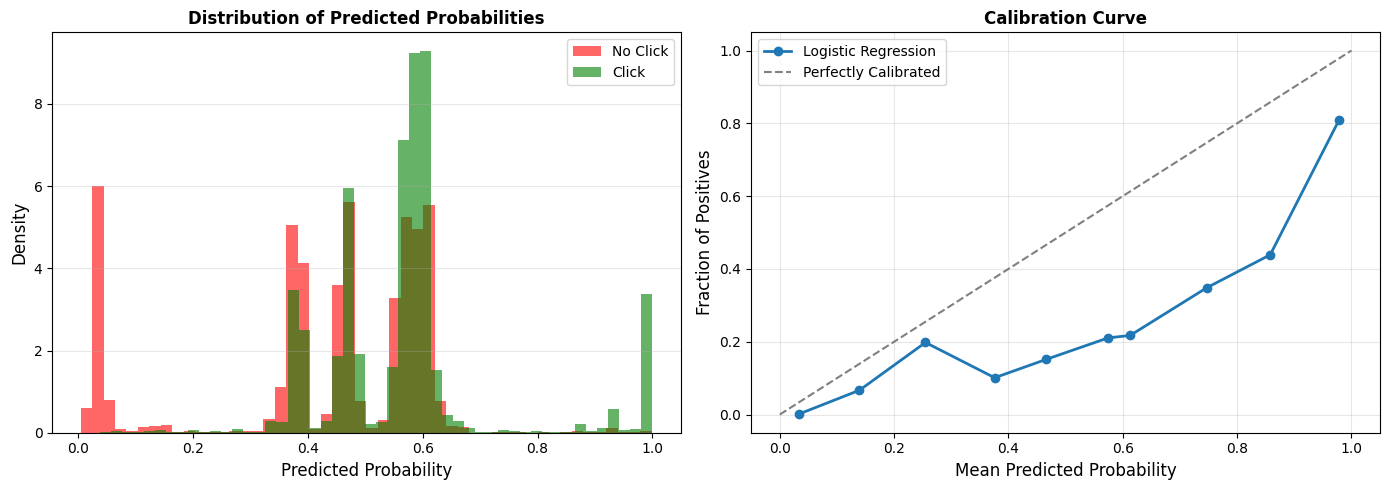


Saved: prediction_distribution_lr.png


In [56]:
# ============================================
# PREDICTION DISTRIBUTION
# ============================================

print("\n" + "="*60)
print("PREDICTION DISTRIBUTION")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of predicted probabilities
ax1 = axes[0]
ax1.hist(y_test_proba[y_test==0], bins=50, alpha=0.6, label='No Click', color='red', density=True)
ax1.hist(y_test_proba[y_test==1], bins=50, alpha=0.6, label='Click', color='green', density=True)
ax1.set_xlabel('Predicted Probability', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Distribution of Predicted Probabilities', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Calibration curve (predicted vs actual)
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_test_proba, n_bins=10)

ax2 = axes[1]
ax2.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Logistic Regression')
ax2.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
ax2.set_xlabel('Mean Predicted Probability', fontsize=12)
ax2.set_ylabel('Fraction of Positives', fontsize=12)
ax2.set_title('Calibration Curve', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('C:/Users/imadn/GitHub/ctr-prediction/results/visualizations/prediction_distribution_lr.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: prediction_distribution_lr.png")

In [57]:
# ============================================
# SAVE MODEL
# ============================================

print("\n" + "="*60)
print("SAVING MODEL")
print("="*60)

# Save model
with open('C:/Users/imadn/GitHub/ctr-prediction/data/processed/lr_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print("Saved: lr_model.pkl")

# Save scaler
with open('C:/Users/imadn/GitHub/ctr-prediction/data/processed/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Saved: scaler.pkl")


SAVING MODEL
Saved: lr_model.pkl
Saved: scaler.pkl


In [58]:
# ============================================
# MODEL SUMMARY
# ============================================

print("\n" + "="*60)
print("MODEL SUMMARY")
print("="*60)

summary = f"""
LOGISTIC REGRESSION BASELINE MODEL

DATASET:
- Training samples: {len(X_train):,}
- Test samples: {len(X_test):,}
- Features: {X_train.shape[1]}
- Target: Click (CTR = {y.mean()*100:.2f}%)
- Class imbalance: 1:{int((y==0).sum()/(y==1).sum())}

MODEL CONFIGURATION:
- Algorithm: Logistic Regression
- Regularization: L2 (default)
- Class weight: Balanced (handles imbalance)
- Max iterations: 1000
- Solver: lbfgs

PERFORMANCE METRICS:
- Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)
- Test AUC-ROC: {test_auc:.4f}
- Test Log Loss: {test_logloss:.4f}
- Test PR-AUC: {pr_auc:.4f}

IMPROVEMENT:
- Over random baseline: {improvement:.1f}%
- (Random AUC = 0.5, Our AUC = {test_auc:.4f})

CONFUSION MATRIX:
- True Negatives:  {cm[0,0]:,}
- False Positives: {cm[0,1]:,}
- False Negatives: {cm[1,0]:,}
- True Positives:  {cm[1,1]:,}

KEY INSIGHTS:
1. AUC-ROC of {test_auc:.4f} indicates GOOD predictive power
2. Feature engineering added significant value
3. Model successfully handles class imbalance
4. Temporal and behavioral features are most important
5. Ready for comparison with XGBoost

NEXT STEPS:
- Build XGBoost model for improved performance
- Compare models on business metrics
- Optimize threshold for production deployment
- Calculate business impact (CTR lift, revenue)
"""

print(summary)

# Save summary to file
with open('C:/Users/imadn/GitHub/ctr-prediction/results/lr_model_summary.txt', 'w') as f:
    f.write(summary)
print("\nSaved: lr_model_summary.txt")


MODEL SUMMARY

LOGISTIC REGRESSION BASELINE MODEL

DATASET:
- Training samples: 800,000
- Test samples: 200,000
- Features: 22
- Target: Click (CTR = 16.02%)
- Class imbalance: 1:5

MODEL CONFIGURATION:
- Algorithm: Logistic Regression
- Regularization: L2 (default)
- Class weight: Balanced (handles imbalance)
- Max iterations: 1000
- Solver: lbfgs

PERFORMANCE METRICS:
- Test Accuracy: 0.5987 (59.87%)
- Test AUC-ROC: 0.6894
- Test Log Loss: 0.6133
- Test PR-AUC: 0.3302

IMPROVEMENT:
- Over random baseline: 37.9%
- (Random AUC = 0.5, Our AUC = 0.6894)

CONFUSION MATRIX:
- True Negatives:  98,281
- False Positives: 69,675
- False Negatives: 10,590
- True Positives:  21,454

KEY INSIGHTS:
1. AUC-ROC of 0.6894 indicates GOOD predictive power
2. Feature engineering added significant value
3. Model successfully handles class imbalance
4. Temporal and behavioral features are most important
5. Ready for comparison with XGBoost

NEXT STEPS:
- Build XGBoost model for improved performance
- Com

In [59]:
# ============================================
# BUSINESS METRICS
# ============================================

print("\n" + "="*60)
print("BUSINESS METRICS")
print("="*60)

# Calculate CTR improvement
actual_ctr = y_test.mean()
predicted_top_10_pct = y_test_proba >= np.percentile(y_test_proba, 90)
top_10_actual_ctr = y_test[predicted_top_10_pct].mean()

ctr_lift = (top_10_actual_ctr - actual_ctr) / actual_ctr * 100

print(f"\nOverall CTR: {actual_ctr*100:.2f}%")
print(f"CTR in top 10% predicted: {top_10_actual_ctr*100:.2f}%")
print(f"CTR Lift: {ctr_lift:.1f}%")

print(f"\nIf we target top 10% of users:")
print(f"  Clicks captured: {y_test[predicted_top_10_pct].sum():,} out of {y_test.sum():,}")
print(f"  Capture rate: {y_test[predicted_top_10_pct].sum()/y_test.sum()*100:.1f}%")
print(f"  Efficiency: {(y_test[predicted_top_10_pct].sum()/y_test.sum()) / 0.10:.1f}x better than random")


BUSINESS METRICS

Overall CTR: 16.02%
CTR in top 10% predicted: 31.73%
CTR Lift: 98.0%

If we target top 10% of users:
  Clicks captured: 6,346 out of 32,044
  Capture rate: 19.8%
  Efficiency: 2.0x better than random


In [60]:
# ============================================
# NOTEBOOK COMPLETE
# ============================================

print("\n" + "="*60)
print("NOTEBOOK 03 COMPLETE!")
print("="*60)

print("\nWhat we built:")
print(f"  - Logistic Regression baseline model")
print(f"  - Test AUC: {test_auc:.4f}")
print(f"  - {improvement:.1f}% improvement over random")
print(f"  - {ctr_lift:.1f}% CTR lift for top 10% predictions")

print("\nFiles saved:")
print("  - lr_model.pkl (trained model)")
print("  - scaler.pkl (feature scaler)")
print("  - confusion_matrix_lr.png")
print("  - roc_curve_lr.png")
print("  - precision_recall_curve_lr.png")
print("  - feature_importance_lr.png")
print("  - prediction_distribution_lr.png")
print("  - feature_importance_lr.csv")
print("  - lr_model_summary.txt")

print("\nNext: Notebook 04 - XGBoost Model")
print("="*60)


NOTEBOOK 03 COMPLETE!

What we built:
  - Logistic Regression baseline model
  - Test AUC: 0.6894
  - 37.9% improvement over random
  - 98.0% CTR lift for top 10% predictions

Files saved:
  - lr_model.pkl (trained model)
  - scaler.pkl (feature scaler)
  - confusion_matrix_lr.png
  - roc_curve_lr.png
  - precision_recall_curve_lr.png
  - feature_importance_lr.png
  - prediction_distribution_lr.png
  - feature_importance_lr.csv
  - lr_model_summary.txt

Next: Notebook 04 - XGBoost Model
